# Human microbiome EASi-seq Data Analysis

#### Project description
Microbial cells are isolated from fecal sample of a health donor. 
The cells are then processed by EASi-seq workflow. 
The single cell libraries are sequenced on Illumina Novaseq platform by Novogene. 
The fastq files are saved in folder: 
`/drive4/xiangpeng/Project/bacteria/novoseq/fastas/usftp21.novogene.com/`
```
humanA_CKDL210003375-1a-AK395-N507_HVFLWDSXY_L4_2.fq.gz
humanA_CKDL210003375-1a-AK395-N507_HVFLWDSXY_L4_1.fq.gz
humanB_CKDL210003375-1a-AK396-N508_HVFLWDSXY_L4_2.fq.gz
humanB_CKDL210003375-1a-AK396-N508_HVFLWDSXY_L4_1.fq.gz
```

### Barcode extraction 
Run mb_barcode_and_trim command to extract the barcode from raw sequencing data FASTQ files

##### Step 1: Barcode extraction

#run the following code in the command line

In [2]:
!mkdir ./splited/hm3/
!python2 ./missionbio-tools/mb_barcode_and_trim_scwga.py HM3 /drive4/xiangpeng/Project/bacteria/novoseq/fastas/usftp21.novogene.com/ ./splited/HM3/ --chem_version V2 --r1_min_len 30 --r2_min_len 30 --min_reads 1000

#this command generate the following documents:
1. the barcode extracted fastq files: "human_R1.fastq.gz", "human_R1.fastq.gz"

The barcode sequence ('TCCAATCATATCGGTGGT-1') has been writen to the header in each entry, shown as following. 
```
@A00738:212:HVFLWDSXY:4:1101:1994:1031_TCCAATCATATCGGTGGT-1
GTTCTTCCCAATGATGGAGCGCCGCCCGGGATACGATGGGAAGCATGCCTGTCCGGCAGTAGCCGACAGCGCCCTGTCCGTGAA
+
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,FFFFFFF
```
2. A CSV file of read counts in each barcode group: "human_barcode_counts.tsv"  

3. Individual pair-end fastq files for each barcode groups (with min read of 1000), such as TCCAATCATATCGGTGGT-1_R1.fq and TCCAATCATATCGGTGGT-1_R2.fq

In [58]:
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import os
from matplotlib.colors import LogNorm, Normalize

##### Step 2: Filter the barcodes by read counts 

In [59]:
# analysis filenames
exp_dir = '/drive4/xiangpeng/Project/bacteria/novoseq/splited/human/'
tsv_path = exp_dir + 'human_barcode_counts.tsv'

In [60]:
# extract barcodes and read totals
all_df = pd.read_csv(tsv_path, sep='\t', index_col=0)

barcodes_all = list(all_df.index)
reads_per_cell = [int(i) for i in list(all_df.sum(axis=1))]

total_reads = sum(reads_per_cell)

reads_per_cell, barcodes_all = (list(t) for t in zip(*sorted(zip(reads_per_cell, barcodes_all), reverse=True)))

print('%d total barcoded reads in experiment' % total_reads)

232705095 total barcoded reads in experiment


Text(0, 0.5, 'Reads per Cell')

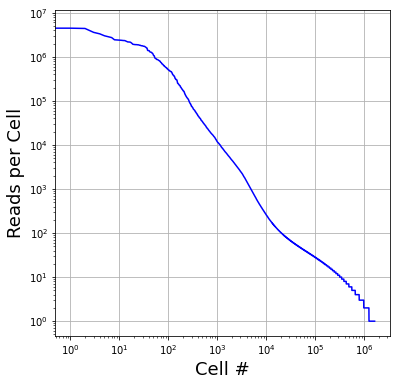

In [61]:
# plot log-log reads per cell vs cells
plt.figure(figsize=(6, 6))
ax = plt.axes()
ax.grid()
plt.loglog(range(len(reads_per_cell)), reads_per_cell, color='b')
plt.xlabel('Cell #', fontsize=18)
plt.ylabel('Reads per Cell', fontsize=18)

In [62]:
# set minimum number of reads per cell
#min_reads = 5000
min_reads = 1000
# create dataframe for called cells only
min_reads_df = all_df.loc[(all_df.sum(axis=1) >= min_reads), :]
valid_barcodes = list(min_reads_df.index)

# print stats
print('%d cells called' % len(min_reads_df.index))
frac_cells = min_reads_df.values.sum()/total_reads
print('Fraction of reads belonging to valid cells: %0.4f' % frac_cells)

4907 cells called
Fraction of reads belonging to valid cells: 0.9318


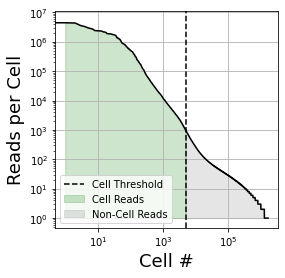

In [63]:
# plot log-log reads per cell vs cells
output_dir = '/drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/analysis/'
n_cells =len(min_reads_df.index)
reads_per_cell.sort(reverse=True)

plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.grid()
plt.loglog(range(len(reads_per_cell)), reads_per_cell, color='k')
plt.axvline(x=n_cells, color='k', linestyle='--', label='Cell Threshold')
plt.xlabel('Cell #', fontsize=18)
plt.ylabel('Reads per Cell', fontsize=18)

#t1 = plt.annotate('N' + r'$_{cells}$' + ' = %d' % n_cells, xy=(2,40), fontsize=14)
#t1.set_bbox(dict(facecolor=None, edgecolor=None, alpha=0))

per_valid = sum(reads_per_cell[0:n_cells]) / sum(reads_per_cell) * 100
#t2 = plt.annotate('%% reads assigned\nto valid cells = %0.1f%%' % per_valid, xy=(2,9), fontsize=14)
#t2.set_bbox(dict(facecolor=None, edgecolor=None, alpha=0))

#t3 = plt.annotate('Mean reads/cell = %d' % np.mean(reads_per_cell[:n_cells]), xy=(2,4), fontsize=14)
#t3.set_bbox(dict(facecolor=None, edgecolor=None, alpha=0))

# fill auc
plt.fill_between(range(1, n_cells), reads_per_cell[1:n_cells], [1] * (n_cells - 1), color='g', alpha=0.2, label='Cell Reads')
total_barcodes = len(reads_per_cell)
plt.fill_between(range(n_cells, total_barcodes), reads_per_cell[n_cells:], [1] * (total_barcodes - n_cells), color='grey', alpha=0.2, label='Non-Cell Reads')
plt.legend()
plt.savefig(output_dir + 'hm3-read_per_cell-vs_cell_count.pdf',bbox_inches='tight')

In [64]:
with open(exp_dir + "valid_barcodes.txt", "w") as f:
    for bar in valid_barcodes:
        f.write(bar +"\n")   
#valide barcodes saved in file valid_barcodes.txt

## Barcode profiling with Kraken
use GTDB database


In [67]:
# process the valid barcodes with Kraken
fq_dir = '/drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/fq/'
kraken_db = '/drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/'
bracken_db = '/drive1/xiangpeng/reference/kraken2/GTDB_release95/bracken/'
kraken_dir = '/drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/'
output_dir = '/drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/analysis/'
bar_uncls = {}# dictionary of barcode: ratio of unmapped reads

bar_uncls_df = pd.DataFrame(columns=['bar','unclassified_ratio', 'read_count'])

for bar in valid_barcodes:
    fq1 = fq_dir + bar + '_R1.fq'
    fq2 = fq_dir + bar + '_R2.fq'
    rpt = kraken_dir + bar + '.kraken'
    outpt = kraken_dir + bar + '.output'
    #command for the kraken2 analysis of each barcodes
    kraken_cmd =  'kraken2  --threads 32 --memory-mapping  --db {} --report {} --output {} --paired {} {}'.format(kraken_db,
                                                                                                                  rpt, 
                                                                                                                  outpt,
                                                                                                                  fq1,
                                                                                                                  fq2
        
                                                                                                                )
    #os.system(kraken_cmd)
    # read the first line of the report and get the unmapped read ratio
    rpt_file = open(rpt, "r")
    first_line = rpt_file.readline()
    second_line = rpt_file.readline()
    rpt_file.close()
    uncls_rate = float(first_line.split('\t')[0].strip(' '))
    read_count = int(first_line.split('\t')[1])
    if second_line != '':
        read_count += int(second_line.split('\t')[1])
    bar_uncls_df.loc[len(bar_uncls_df)]=[bar, uncls_rate, read_count]

  

In [74]:
bar_uncls_df= bar_uncls_df.set_index('bar')
bar_uncls_df.to_csv(output_dir + 'HM3_barcode_read_count_and_kraken_unclassified_rate.csv')

In [73]:
bar_uncls_df =  pd.read_csv('/drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/analysis/HM3_barcode_read_count_and_kraken_unclassified_rate.csv')

'/drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/analysis/'

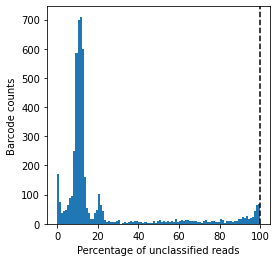

In [56]:
# filter data by unclassified ratio
max_unmap = 100 # select the barcode groups with maxmum 20% read that are not mapped
data = bar_uncls_df['unclassified_ratio'].tolist()

fig, ax = plt.subplots(figsize=(4,4))
N,bins,patches = ax.hist(data, 
                         #edgecolor = 'white', 
                         #linewidth =1,
                         bins =100)
plt.axvline(x=max_unmap, color='k', 
            linestyle='--', 
            label='Cell Threshold')

for i in range(max_unmap,100):    
    patches[i].set_facecolor('grey')
plt.xlabel('Percentage of unclassified reads')#, fontsize=16)
plt.ylabel('Barcode counts')#, fontsize=16)
#plt.title('Perentage of reads not classified by Kraken', fontsize = 16)
plt.savefig(output_dir+'HM3_filter_by_kraken_ummap_rate.pdf')
plt.show()

In [57]:
filtered_bars =  bar_uncls_df[bar_uncls_df['unclassified_ratio']<=max_unmap].index.tolist()
print(len(filtered_bars))

4907


In [58]:
# bracken analysis of the kraken output files with filtered barcodes. 
bar_gns_abd =  pd.DataFrame() # Dataframe of the genus abundace of each barcode group

for bar in filtered_bars:
    # bracken process the kraken output data
    rpt = kraken_dir + bar + '.kraken'
    brk = kraken_dir + bar + '_G.bracken' # bracken output file at Genus level
    brk_cmd =  'bracken -d {} -l G -i {} -o {}'.format(kraken_db,rpt,brk)
    #print(brk_cmd)
    #os.system(brk_cmd)
    
    # read the bracke output file and combine into a dataframe
    try:
        df = pd.read_csv(brk, sep = '\t', index_col = 0) # read the bracken output into a pd dataframe.
        df = df.rename(columns = {'fraction_total_reads': bar})
        bar_gns_abd = pd.concat([bar_gns_abd, df[bar]], axis =1)
    except FileNotFoundError:
        continue
bar_gns_abd = bar_gns_abd.fillna(0)

In [59]:
bar_gns = bar_gns_abd.T
bar_gns.to_csv(output_dir + 'HM3_filtered_barcode_kraken_genus_abundance.csv')

In [60]:
column_ls = bar_gns.columns.to_list()
bar_gns['purity']=bar_gns[column_ls].max(axis=1)
bar_gns['Genus']=bar_gns[column_ls].idxmax(axis=1)
bar_gns.head()

,g__Bifidobacterium,g__Collinsella,g__Blautia_A,g__RPRI01,g__Dorea,g__Roseburia,g__UBA11774,g__Anaerobutyricum,g__Eubacterium_G,g__UBA9502,...,g__CSBr16-57R1,g__QHXZ01,g__CF-39,g__Gallaecimonas,g__28-57-27,g__UBA1768,g__Anaerosporomusa,g__UBA7741,purity,Genus
TGAACTTGCTTAAGTGGT-1,0.24590,0.28689,0.34426,0.12295,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.34426,g__Blautia_A
CATAGTATGCTGGTACAT-1,0.11915,0.01238,0.57902,0.00000,0.02550,0.00814,0.00621,0.00589,0.00471,0.00327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.57902,g__Blautia_A
AGATATGGAGATTAGACA-1,0.09238,0.01145,0.62061,0.00000,0.03316,0.00671,0.00000,0.00000,0.01105,0.00395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.62061,g__Blautia_A
CCAATATACAGACATCCA-1,0.10652,0.22186,0.40443,0.00000,0.00277,0.01158,0.00000,0.09418,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.40443,g__Blautia_A
TCCTGTGGAATCTCTGCT-1,0.00014,0.00020,0.90958,0.00000,0.00413,0.01442,0.00003,0.01277,0.00176,0.00041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.90958,g__Blautia_A


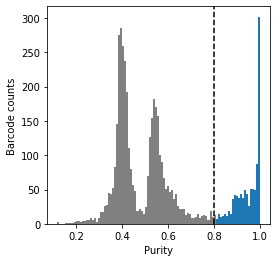

In [74]:
min_purity =0.8

fig, ax = plt.subplots(figsize=(4,4))
plt.axvline(x=min_purity, color='k', linestyle='--', label='Cell Threshold')
n, bins, patches = plt.hist(bar_gns['purity'], bins=100)
for c,p in zip(bins, patches):
    if c < min_purity:
        plt.setp(p, 'facecolor', 'grey')

plt.xlabel('Purity')#, fontsize=16)
plt.ylabel('Barcode counts')#, fontsize=16)
#plt.title('Perentage of reads not classified by Kraken', fontsize = 16)
plt.savefig(output_dir+'HM3_filter_genuse_level_purity.pdf')

In [91]:
pure_bar_gns = bar_gns[bar_gns['purity']>=min_purity]
#pure_bar_gns = bar_gns[bar_gns['purity']>=0.715]
pure_bar_gns.to_csv(output_dir+'HM3_purity_filtered_genus_matrix.csv')

#### Cell-Cell interaction in barcode with 2 cells

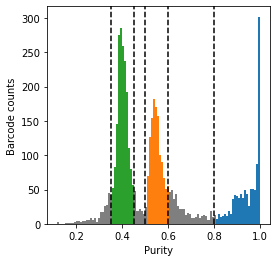

In [65]:
min_purity =0.8

purity_60 = 0.6
purity_50 = 0.5

purity_45 = 0.45
purity_35 = 0.35

fig, ax = plt.subplots(figsize=(4,4))
plt.axvline(x=min_purity, color='k', linestyle='--', label='Cell Threshold')
plt.axvline(x=purity_60, color='k', linestyle='--', label='Cell Threshold')
plt.axvline(x=purity_50, color='k', linestyle='--', label='Cell Threshold')
plt.axvline(x=purity_45, color='k', linestyle='--', label='Cell Threshold')
plt.axvline(x=purity_35, color='k', linestyle='--', label='Cell Threshold')


n, bins, patches = plt.hist(bar_gns['purity'], bins=100)
for c,p in zip(bins, patches):
    if c < min_purity:
        plt.setp(p, 'facecolor', 'tab:grey')
    if (c > purity_50) & (c < purity_60):
        plt.setp(p, 'facecolor', 'tab:orange')
    if (c > purity_35) & (c < purity_45):
        plt.setp(p, 'facecolor', 'tab:green')

plt.xlabel('Purity')#, fontsize=16)
plt.ylabel('Barcode counts')#, fontsize=16)
#plt.title('Perentage of reads not classified by Kraken', fontsize = 16)
plt.savefig(output_dir+'HM3_filter_genuse_level_purity_2.pdf')

In [93]:
bars_with_2cells=bar_gns[(bar_gns['purity']>=purity_50)&(bar_gns['purity']<=purity_60)]
print(len(bars_with_2cells))
bars_with_2cells.head()

1226


,g__Bifidobacterium,g__Collinsella,g__Blautia_A,g__RPRI01,g__Dorea,g__Roseburia,g__UBA11774,g__Anaerobutyricum,g__Eubacterium_G,g__UBA9502,...,g__CSBr16-57R1,g__QHXZ01,g__CF-39,g__Gallaecimonas,g__28-57-27,g__UBA1768,g__Anaerosporomusa,g__UBA7741,purity,Genus
CATAGTATGCTGGTACAT-1,0.11915,0.01238,0.57902,0.0,0.02550,0.00814,0.00621,0.00589,0.00471,0.00327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.57902,g__Blautia_A
ACCATTCACGTGGACTGG-1,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.55556,g__Blastococcus
CAGTACATCACTACTCAT-1,0.11679,0.01174,0.58529,0.0,0.03908,0.00594,0.00000,0.01932,0.00520,0.00505,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.58529,g__Blautia_A
CGATTCGAGTAGACACGT-1,0.00083,0.59355,0.05020,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.59355,g__Collinsella
TAGCAGAGTCCGTCCACT-1,0.00000,0.44118,0.52941,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.52941,g__Blautia_A


In [94]:
bars_with_2cells['2nd_Genus'] = bars_with_2cells[column_ls].T.apply(lambda x: x.nlargest(2).idxmin())
bars_with_2cells.head()

/tmp/ipykernel_28963/612615591.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bars_with_2cells['2nd_Genus'] = bars_with_2cells[column_ls].T.apply(lambda x: x.nlargest(2).idxmin())


,g__Bifidobacterium,g__Collinsella,g__Blautia_A,g__RPRI01,g__Dorea,g__Roseburia,g__UBA11774,g__Anaerobutyricum,g__Eubacterium_G,g__UBA9502,...,g__QHXZ01,g__CF-39,g__Gallaecimonas,g__28-57-27,g__UBA1768,g__Anaerosporomusa,g__UBA7741,purity,Genus,2nd_Genus
CATAGTATGCTGGTACAT-1,0.11915,0.01238,0.57902,0.0,0.02550,0.00814,0.00621,0.00589,0.00471,0.00327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.57902,g__Blautia_A,g__Bifidobacterium
ACCATTCACGTGGACTGG-1,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.55556,g__Blastococcus,g__Nocardioides
CAGTACATCACTACTCAT-1,0.11679,0.01174,0.58529,0.0,0.03908,0.00594,0.00000,0.01932,0.00520,0.00505,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.58529,g__Blautia_A,g__Senegalimassilia
CGATTCGAGTAGACACGT-1,0.00083,0.59355,0.05020,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.59355,g__Collinsella,g__Streptococcus
TAGCAGAGTCCGTCCACT-1,0.00000,0.44118,0.52941,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.52941,g__Blautia_A,g__Collinsella


In [96]:
interact_df = bars_with_2cells[['Genus','2nd_Genus']]
interact_df['count']=1

/tmp/ipykernel_28963/3570796098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interact_df['count']=1


In [99]:
interact_df = interact_df.groupby(by=['Genus','2nd_Genus']).sum()

In [118]:
interact_df = interact_df[interact_df['count']>1]
interact_df = pd.pivot_table(interact_df, columns=['Genus'], index=['2nd_Genus'], values=['count'])
interact_df = interact_df.fillna(0)

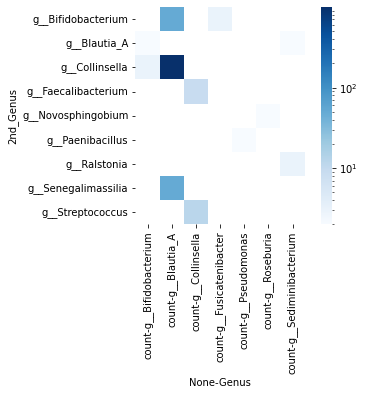

In [120]:
sns.heatmap(interact_df,
            norm=LogNorm(),
            square=True,
            cmap = 'Blues'
           )
plt.savefig(output_dir+'HM3_2cell_interaction_heatmap_2.pdf')

In [122]:
interact_df.to_csv(output_dir+'HM3_2cell_interaction_heatmap_2.csv')

### UMAP clustering and visulization

In [3]:
output_dir = '/drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/analysis/'
pure_bar_gns = pd.read_csv(output_dir+'HM3_purity_filtered_genus_matrix.csv', index_col =0)

In [6]:
adata_g =  anndata.AnnData(pure_bar_gns.drop(columns=['purity','Genus']), dtype=np.float32)

In [7]:
sc.pp.neighbors(adata_g, use_rep='X')#, n_neighbors=100)
sc.tl.leiden(adata_g, resolution=1)

In [8]:
sc.tl.umap(adata_g)

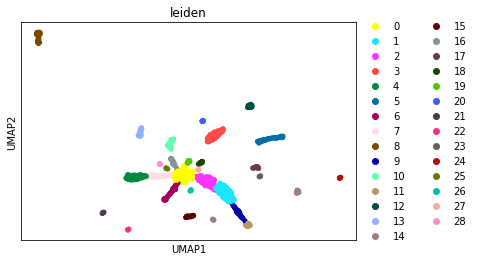

In [9]:
sc.pl.umap(adata_g, color='leiden')

In [43]:
dic_bar_genera= pure_bar_gns['Genus'].to_dict()
gns_cnt=pure_bar_gns['Genus'].value_counts()

dic_bar_genera_fixed ={}
for bar in dic_bar_genera:
    genus = dic_bar_genera[bar] 
    if gns_cnt[genus] <=1: # because the list is too long, if the appearace of genus is less than 10 barcodes, then assign it as other
        dic_bar_genera_fixed[bar] = 'other'
    else:
        dic_bar_genera_fixed[bar]= genus
        
        
adata_g.obs['genus']=adata_g.obs.index.map(dic_bar_genera_fixed).astype('category')
adata_g.obs['genus2']=adata_g.obs.index.map(dic_bar_genera).astype('category')

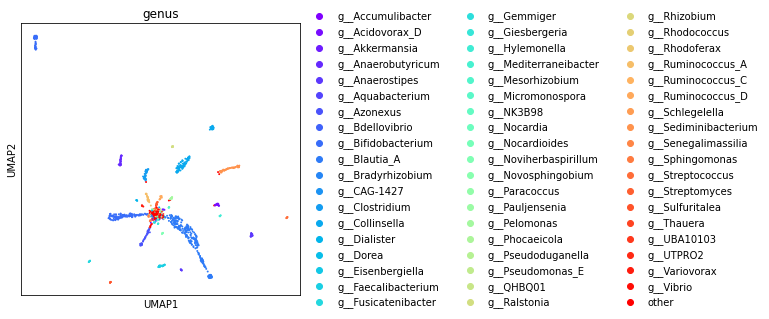

In [45]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata_g, 
               color='genus',
               size =15,
               color_map=plt.cm.Reds,
               palette="rainbow")

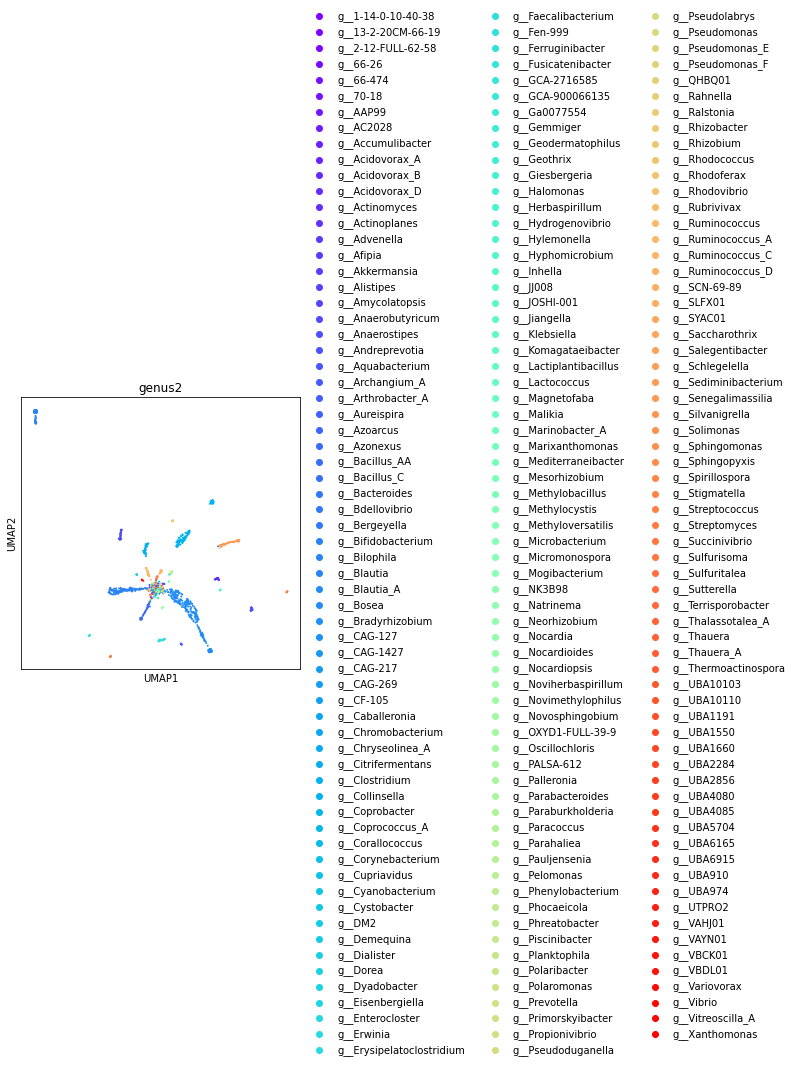

In [44]:

from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata_g, 
               color='genus2',
               size =15,
               color_map=plt.cm.Reds,
               palette="rainbow")

In [46]:
pure_bar_gns['Genus'].value_counts()

g__Blautia_A            277
g__Bifidobacterium      166
g__Collinsella          106
g__Sediminibacterium     53
g__Azonexus              46
                       ... 
g__Natrinema              1
g__UBA10110               1
g__Cupriavidus            1
g__VAYN01                 1
g__Demequina              1
Name: Genus, Length: 197, dtype: int64

In [47]:
adata_g.write(output_dir + 'hm3_sc_genus_level_filtered_adata_2.h5ad')

### Combine groups by barcodes

In [55]:
cluster_df = adata_g.obs

In [56]:
cluster_ls = cluster_df['genus2'].unique().to_list()
print(*cluster_ls,sep=', ')

g__Blautia_A, g__Collinsella, g__Bifidobacterium, g__Clostridium, g__Anaerostipes, g__Pseudoduganella, g__Sediminibacterium, g__Azonexus, g__Acidovorax_D, g__UBA1660, g__VBDL01, g__Gemmiger, g__Vibrio, g__Ruminococcus_A, g__Mogibacterium, g__Arthrobacter_A, g__Streptomyces, g__Faecalibacterium, g__Senegalimassilia, g__Fusicatenibacter, g__Anaerobutyricum, g__66-474, g__Corynebacterium, g__Pelomonas, g__Dialister, g__Ga0077554, g__Andreprevotia, g__Ruminococcus_D, g__Rahnella, g__Mediterraneibacter, g__Sulfuritalea, g__UBA6915, g__UBA2284, g__Actinomyces, g__Thauera_A, g__Rhodovibrio, g__UBA1550, g__UBA4085, g__Streptococcus, g__VBCK01, g__Primorskyibacter, g__Ferruginibacter, g__Amycolatopsis, g__Rhodoferax, g__Cyanobacterium, g__Chryseolinea_A, g__Bosea, g__Inhella, g__UTPRO2, g__Schlegelella, g__Ralstonia, g__Herbaspirillum, g__Hydrogenovibrio, g__Parahaliea, g__CAG-1427, g__Akkermansia, g__Bradyrhizobium, g__13-2-20CM-66-19, g__Aquabacterium, g__UBA974, g__Propionivibrio, g__Sulfuri

In [53]:
#combine all EASi-seq reads by clusters
cluster_stat = pd.DataFrame(index=cluster_ID_ls, columns=['sc_bar_cnt', 'contig_bar_cnt'])# make a new cluster to 

for cluster in cluster_ls:
    

g__Blautia_A, g__Collinsella, g__Bifidobacterium, g__Clostridium, g__Anaerostipes, g__Pseudoduganella, g__Sediminibacterium, g__Azonexus, g__Acidovorax_D, g__UBA1660, g__VBDL01, g__Gemmiger, g__Vibrio, g__Ruminococcus_A, g__Mogibacterium, g__Arthrobacter_A, g__Streptomyces, g__Faecalibacterium, g__Senegalimassilia, g__Fusicatenibacter, g__Anaerobutyricum, g__66-474, g__Corynebacterium, g__Pelomonas, g__Dialister, g__Ga0077554, g__Andreprevotia, g__Ruminococcus_D, g__Rahnella, g__Mediterraneibacter, g__Sulfuritalea, g__UBA6915, g__UBA2284, g__Actinomyces, g__Thauera_A, g__Rhodovibrio, g__UBA1550, g__UBA4085, g__Streptococcus, g__VBCK01, g__Primorskyibacter, g__Ferruginibacter, g__Amycolatopsis, g__Rhodoferax, g__Cyanobacterium, g__Chryseolinea_A, g__Bosea, g__Inhella, g__UTPRO2, g__Schlegelella, g__Ralstonia, g__Herbaspirillum, g__Hydrogenovibrio, g__Parahaliea, g__CAG-1427, g__Akkermansia, g__Bradyrhizobium, g__13-2-20CM-66-19, g__Aquabacterium, g__UBA974, g__Propionivibrio, g__Sulfuri

In [54]:
cluster_df.head()

,leiden,genus,genus2
TCCTGTGGAATCTCTGCT-1,1,g__Blautia_A,g__Blautia_A
ACGGTGCCTAAGCCACAC-1,3,g__Collinsella,g__Collinsella
AGTAGAGGACCAAGTCGA-1,7,g__Bifidobacterium,g__Bifidobacterium
CAGCGACGTTGAGAATCC-1,1,g__Blautia_A,g__Blautia_A
AGGTACCAACAATCTCCG-1,10,g__Clostridium,g__Clostridium
